# Ebro: catchment 626

This subcatchment is a very small catchment constrained upstream by station 607 and downstream by station 628. There is one reservoir (4137) just upstream from the outlet, whose inflow is mostly the streamflow in the upstream station 607, although there is a tributary on the South, even if its catchment area is smaller. 

***Table 1**. Reservoir ID in the Global Dam Watch (GDW), Global Reservoir and Dam (GRanD) database and EFAS.*

| GDW_ID | GRanD_ID | EFAS_ID |
| ------ | -------- | ------- |
| 1423 | 2684 | 9453 |

***Figure 1**. Scheme of the catchment including reservoirs (pink triangle) and gauging stations used for calibration (circles).*

<img src="./images/626.png" alt="Catchment scheme" width="800"/>

In [61]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

In [2]:
from lisfloodreservoirs.calibration import read_results
from lisfloodreservoirs.calibration.camaflood_calibrator import CamafloodCalibrator
from lisfloodreservoirs.models import get_model
from lisfloodreservoirs.models import Camaflood
from lisfloodreservoirs.utils.metrics import KGEmod

In [3]:
import spotpy

## Configuration

In [4]:
path_efas = Path('Z:/nahaUsers/casadje/EFASv6/reservoirs/')
path_catchment = path_efas / 'tests' / 'Ebro'
path_obs = path_catchment / 'HYDRO' / 'timeseries'
path_resops = Path('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsES/v3.0')

### Reservoirs

In [20]:
# reservoirs in the catchment
reservoirs = {
    1423: {
        # 'GRAND_ID': 2684,
        'EFAS_ID': 9453
    }
}
reservoirs = pd.DataFrame.from_dict(reservoirs, orient='index').rename_axis('GDW_ID')

In [21]:
# import reservoirs in EFAS6
res_efas6 = gpd.read_file(
    path_efas / 'tables' / 'reservoirs_efas6_20250303.shp'
).set_index('GDW_ID')
res_efas6.GRAND_ID = res_efas6.GRAND_ID.astype('Int64')

# add calibrated/estimated parameters
for parname in ['flood_storage', 'outflow_factor']:
    series = pd.read_csv(
        path_efas / 'tables' / 'parameters' / f'reservoirs_efas6_{parname}.txt', 
        header=None,
        index_col=0,
        sep='\t'
    ).squeeze()
    series.index.name = 'GDW_ID',
    series.name = parname
    res_efas6 = pd.concat((res_efas6, series), axis=1)
res_efas6.index.name = 'GDW_ID'

print(f'{len(res_efas6)} reservoirs in total')

reservoirs = pd.concat([reservoirs, res_efas6], axis=1, join='inner')
print(f'{len(reservoirs)} reservoirs in the catchment')

gdw_id = reservoirs.index[0]

1545 reservoirs in total
1 reservoirs in the catchment


In [22]:
# extract reservoir characteristics
cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
# extract inflow characteristics
Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
# extract reservoir parameters
par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_storage', 'outflow_factor']]

## Observation

### Streamflow

#### Downstream

In [8]:
# observed streamflow in the gauging station
efas_id = 626
streamflow_ds = pd.read_csv(path_obs / f'{efas_id}.csv', index_col=0, parse_dates=True).squeeze()
streamflow_ds.name = 'downstream'

#### Upstream

In [9]:
# observed streamflow in the upstream gauging station
streamflow_us = []
for efas_id in [637, 2809]:
    serie = pd.read_csv(path_obs / f'{efas_id}.csv', index_col=0, parse_dates=True).squeeze()
    serie.name = efas_id
    streamflow_us.append(serie)
streamflow_us = pd.concat(streamflow_us, axis=1).sum(axis=1)
streamflow_us.name = 'upstream'

#### Merge

In [10]:
streamflow = pd.concat([streamflow_us, streamflow_ds], axis=1)
mask = streamflow.notnull().all(axis=1)
start, end = streamflow[mask].index[0], streamflow[mask].index[-1]
streamflow = streamflow.loc[start:end]

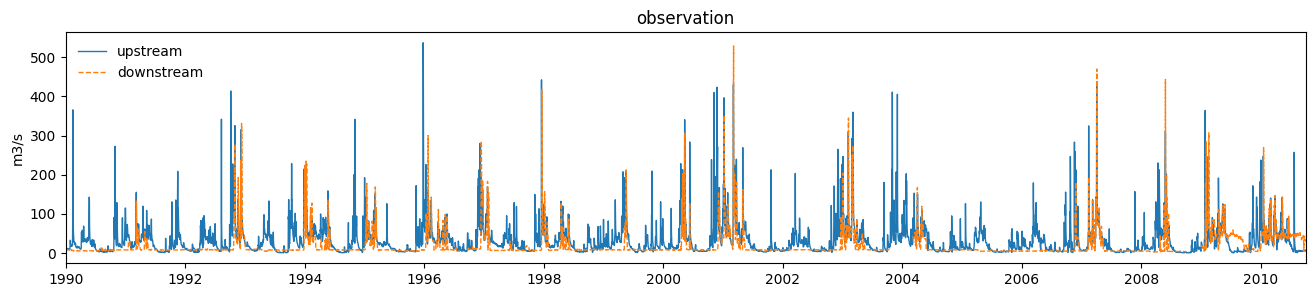

In [11]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(
    streamflow.upstream,
    lw=1,
    label='upstream'
)
ax.plot(
    streamflow.downstream,
    lw=1,
    ls='--',
    label='downstream'
)
ax.set(
    xlim=(start, end),
    ylabel='m3/s',
    title='observation'
)
ax.legend(frameon=False);

In [48]:
streamflow.downstream.sum() / streamflow.upstream.sum()

np.float64(0.5557066430532527)

There is a clear difference between the upstream and downstream discharge time series. Most of the high flows disappear and there's a constant minimum value in the downstream discharge.

### Release

#### ResOpsES

In [32]:
for gdw_id, row in reservoirs.iterrows():
    grand_id = row.GRAND_ID
    file = path_resops / 'time_series' / 'csv' / f'{grand_id}.csv'
    if file.is_file():
        resops = pd.read_csv(file, parse_dates=True, index_col=0, usecols=['date', 'outflow', 'storage'])
    else:
        print(f'{file} does not exist')
# convert storage to hm3
resops.storage *= 1e6
# create dummy inflow time series
resops['inflow'] = np.nan

#### HYDRO

In [28]:
for gdw_id, row in reservoirs.iterrows():
    efas_id = row.EFAS_ID
    file = path_obs / f'{efas_id}.csv'
    if file.is_file():
        hydro = pd.read_csv(file, index_col=0, parse_dates=True)
        # hydro.name = 'outflow'
    else:
        print(f'{file} does not exist')
# convert storage to hm3
hydro.storage *= 1e6
# create dummy inflow time series
hydro['inflow'] = np.nan

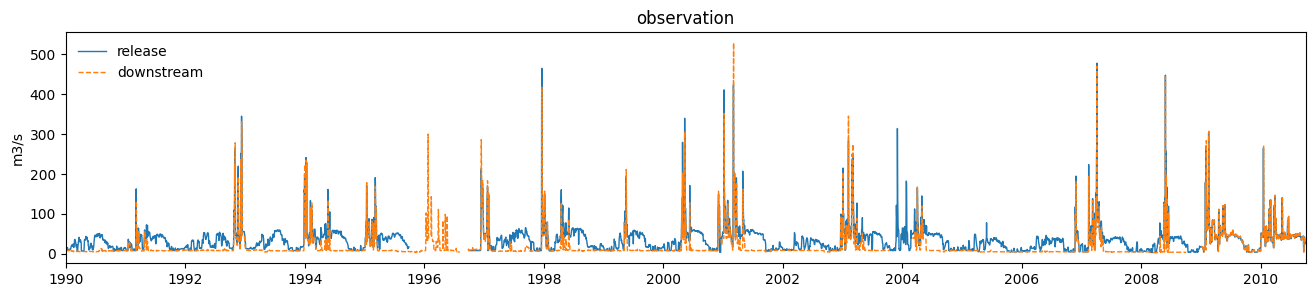

In [29]:
fig, ax = plt.subplots(figsize=(16, 3))

ax.plot(
    hydro['outflow'],
    lw=1,
    ls='-',
    label='release'
)
ax.plot(
    streamflow.downstream,
    lw=1,
    ls='--',
    label='downstream'
)
ax.set(
    xlim=(start, end),
    ylabel='m3/s',
    title='observation'
)
ax.legend(frameon=False);

The streamflow in the downstream station is basically the same as the reservoir release, besides the peak at the end of 2002.

### Simulated

In [35]:
sim_files = {
    'inflow': path_catchment / 'RES_inflow.csv',
    'outflow': path_catchment / 'RES_outflow.csv',
    'storage': path_catchment / 'RES_fill.csv'
}

In [36]:
efas6 = pd.DataFrame(dtype=float)
for var, file in sim_files.items():
    # load simulated time series
    data = pd.read_csv(
        file, 
        parse_dates=True, 
        index_col=0
    )
    data.columns = data.columns.astype(int)
    data.index = pd.to_datetime(data.index, format='%d/%m/%Y %H:%M')

    if gdw_id in data.columns:
        serie = data[gdw_id]
        if var == 'storage':
            serie *= cap_cm #reservoirs.loc[gdw_id, 'CAP_MCM'] * 1e6
        efas6[var] = serie
    else:
        print(f'{gdw_id} was not found in the {var} simulated time series')        

In [37]:
# resample daily
efas6_d = efas6.groupby(efas6.index.floor('D')).mean()

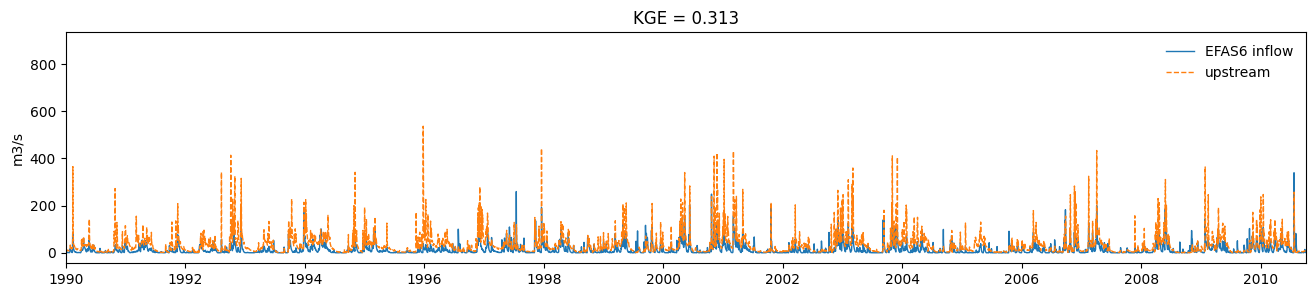

In [39]:
fig, ax = plt.subplots(figsize=(16, 3))

ax.plot(
    efas6_d['inflow'],
    lw=1,
    ls='-',
    label='EFAS6 inflow'
)
ax.plot(
    streamflow.upstream,
    lw=1,
    ls='--',
    label='upstream'
)
kge = KGEmod(obs=streamflow.upstream, sim=efas6_d['inflow'])[0]
ax.set(
    xlim=(start, end),
    ylabel='m3/s',
    title=f'KGE = {kge:.3f}'
)

ax.legend(frameon=False);

The analysis above simplifies the reservoir as it has a third inflow. However, in terms of catchment area, the two inflows considered here are the vast majority of the contributing area.

## Analysis

In [40]:
path_results = path_catchment / '626'
path_results.mkdir(parents=True, exist_ok=True)

### EFAS6 simulation

In [41]:
# define reservoir limits
Vf = par_Vf * cap_cm
Ve = cap_cm * (0.8 + 0.2 * par_Vf)
Vmin = 0.5 * Vf
Qf = Q100 * par_Qf
Qmin = 0.5 * Qn

# reservoir limits
Vlims = [Vmin, Vf, Ve, cap_cm]
Qlims = [Qmin, Qf, Qf, Qf]

In [42]:
# declare reservoir
res = Camaflood(
    Vmin=Vmin,
    Vf=Vf,
    Ve=Ve,
    Vtot=cap_cm,
    Qn=Qn,
    Qf=Qf,
    catchment=catch_sm,
    Atot=area_sm,
    timestep=6*3600
)

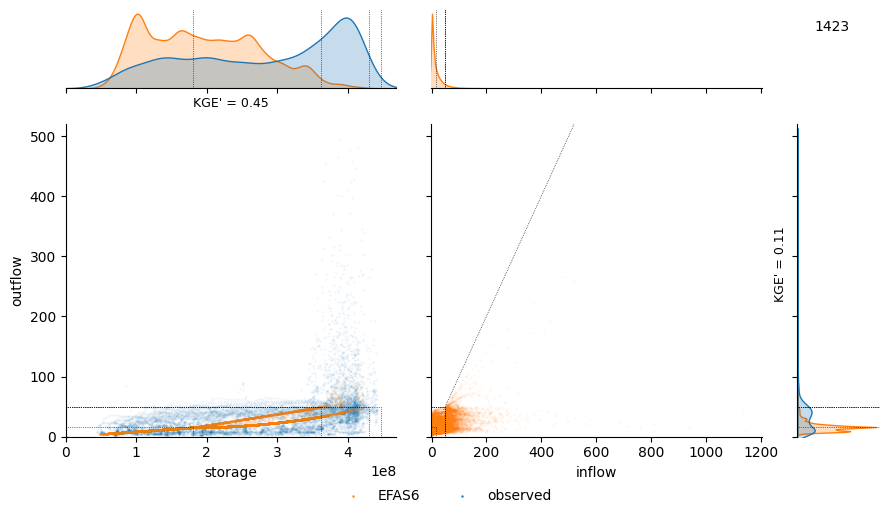

In [43]:
# compare LISFLOOD vs observation
res.scatter(
    efas6,
    hydro,
    norm=False,
    title=gdw_id,
    Vlims=Vlims,
    Qlims=Qlims,
    labels=['EFAS6', 'observed'],
    # save=path_results / f'{gdw_id}_scatter_efas6_vs_observed.jpg'
)

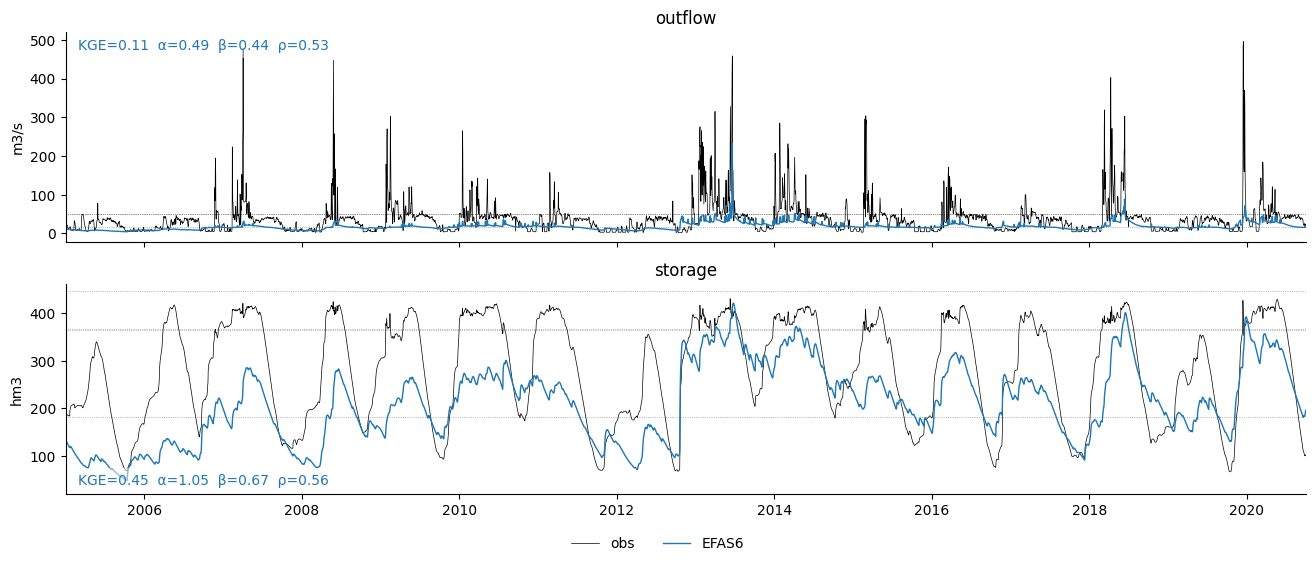

In [63]:
res.lineplot(
    sim={
        'EFAS6': efas6_d,
    },
    obs=hydro,
    Vlims=Vlims,
    Qlims=Qlims,
    # spinup=cfg.SPINUP,
    title=gdw_id,
    figsize=(16, 6),
    xlim=(datetime(2005, 1, 1), datetime(2020, 9, 30))
    # save=path_results / f'{gdw_id}_line_efas6_vs_observed.jpg'
)

In [76]:
efas6_d.index.min(), efas6_d.index.max()

(Timestamp('1987-01-01 00:00:00'), Timestamp('2024-01-01 00:00:00'))

In [77]:
streamflow.index.min(), streamflow.index.max()

(Timestamp('1990-01-01 00:00:00'), Timestamp('2010-10-01 00:00:00'))

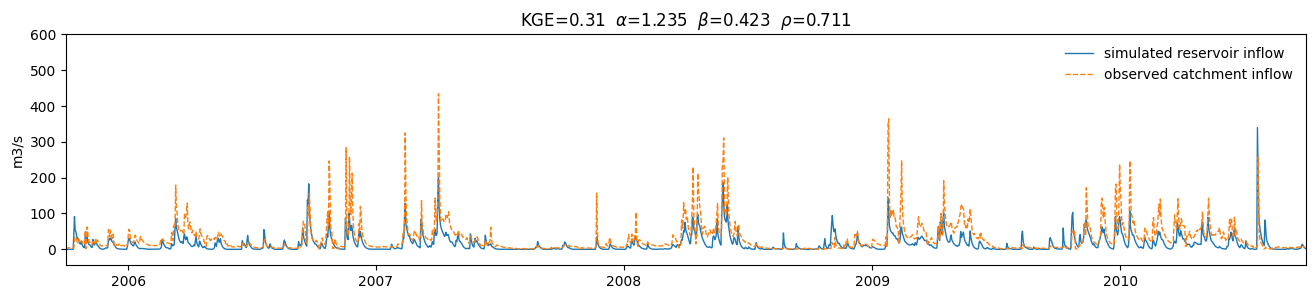

In [82]:
fig, ax = plt.subplots(figsize=(16, 3))

ax.plot(
    efas6_d.inflow,
    lw=1,
    ls='-',
    label='simulated reservoir inflow'
)
ax.plot(
    streamflow.upstream,
    lw=1,
    ls='--',
    label='observed catchment inflow'
)
kge, alpha, beta, r = KGEmod(obs=streamflow.upstream, sim=efas6_d.inflow)
ax.set(
    xlim=(datetime(2005, 10, 1), datetime(2010, 10, 1)),
    ylim=(None, 600),
    ylabel='m3/s',
    title=fr'KGE={kge:.2f}  $\alpha$={alpha:.3f}  $\beta$={beta:.3f}  $\rho$={r:.3f}'
)

ax.legend(frameon=False);

### Simulate CaMa-Flood

In [45]:
sim = res.simulate(
    inflow=efas6.inflow,
    Vo=None,
)

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

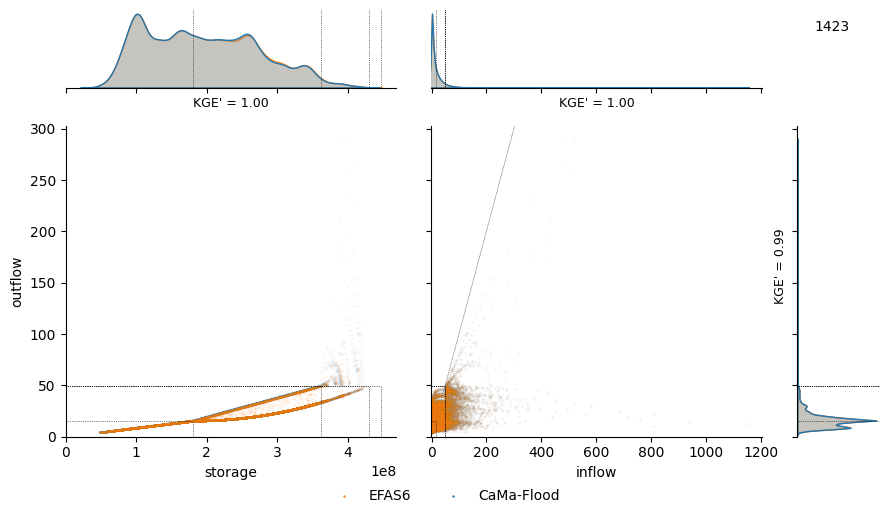

In [46]:
# compare EFAS6 vs CaMa-Flood
res.scatter(
    efas6,
    sim,
    norm=False,
    title=gdw_id,
    Vlims=Vlims,
    Qlims=Qlims,
    labels=['EFAS6', 'CaMa-Flood'],
    spinup=365,
    # save=path_results / f'{gdw_id}_scatter_efas6_vs_observed.jpg'
)

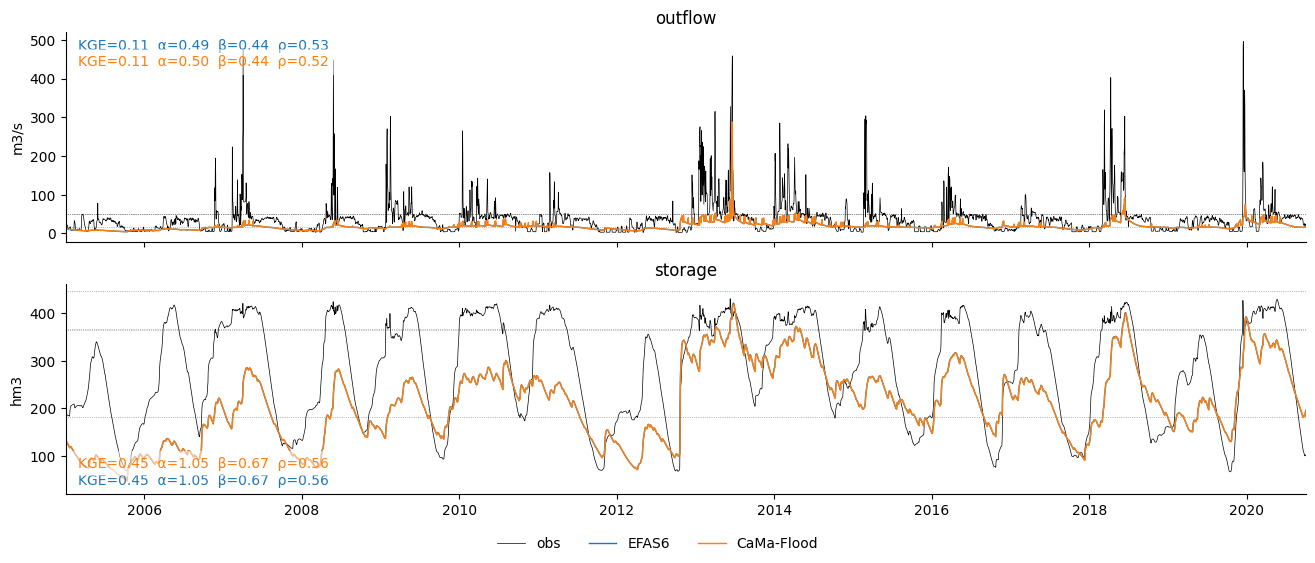

In [66]:
res.lineplot(
    sim={
        'EFAS6': efas6_d,
        'CaMa-Flood': sim,
    },
    obs=hydro,
    Vlims=Vlims,
    Qlims=Qlims,
    # spinup=365,
    title=gdw_id,
    figsize=(16, 6),
    xlim=(datetime(2005, 1, 1), datetime(2020, 9, 30))
    # save=path_results / f'{gdw_id}_line_efas6_vs_observed.jpg'
)

The plots above prove that the CaMa-Flood routine in OS-LISFLOOD behaves as expected (as the isolated routine in `lisflood-reservoirs`) at 6-hour time steps.

### Calibrate CaMa-Flood

In [49]:
parameters_cal = {
    'alpha': {
        'low': 0.2,
        'high': 0.99
    },
    'delta': {
        'low': 0.1,
        'high': 0.5
    },
}

target = ['storage', 'outflow']

In [50]:
# time series: simulated inflow, observed storage and outflow
cal_ts = pd.concat([efas6_d.inflow, hydro.storage, hydro.outflow], axis=1)
mask = cal_ts.notnull().all(axis=1)
start, end = cal_ts[mask].index[0], cal_ts[mask].index[-1]
cal_ts = cal_ts.loc[start:end]

In [51]:
# declare reservoir
calibrator = CamafloodCalibrator(
    parameters=parameters_cal,
    inflow=cal_ts.inflow,
    storage=cal_ts.storage,
    outflow=cal_ts.outflow,
    Vmin=max(0, min(0.1 * cap_cm, cal_ts.storage.min())),
    Vtot=cap_cm,
    catchment=catch_sm,
    # Atot=area_sm,
    target=target,
    obj_func=KGEmod,
    spinup=365,
)

# define the sampling method
dbname = f'{path_results}/{gdw_id}_samples'
sceua = spotpy.algorithms.sceua(
    calibrator, 
    dbname=dbname, 
    dbformat='csv', 
    save_sim=False,
)

# launch calibration
sceua.sample(
    5000, 
    ngs=4, 
    kstop=5, 
    pcento=0.001, 
    peps=0.01
)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  5000  repetitions
The objective function will be minimized
Starting burn-in sampling...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'Z:\nahaUsers\casadje\EFASv6\reservoirs\tests\Ebro\626/1423_samples.csv' created.


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

6 of 5000, minimal objective function=1.33175, time remaining: 00:26:12


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

12 of 5000, minimal objective function=1.01307, time remaining: 00:28:00


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

17 of 5000, minimal objective function=1.01307, time remaining: 00:29:26


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

27 of 5000, minimal objective function=1.01307, time remaining: 00:28:28


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

41 of 5000, minimal objective function=1.01307, time remaining: 00:25:20


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

53 of 5000, minimal objective function=1.00465, time remaining: 00:23:49


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

64 of 5000, minimal objective function=1.00465, time remaining: 00:22:31
ComplexEvo loop #2 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

77 of 5000, minimal objective function=1.00465, time remaining: 00:21:46


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

92 of 5000, minimal objective function=1.00465, time remaining: 00:21:32


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

106 of 5000, minimal objective function=1.00465, time remaining: 00:21:08


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

118 of 5000, minimal objective function=1.00465, time remaining: 00:20:41
ComplexEvo loop #3 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

133 of 5000, minimal objective function=1.00465, time remaining: 00:20:38


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

147 of 5000, minimal objective function=1.00465, time remaining: 00:20:24


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

161 of 5000, minimal objective function=1.00465, time remaining: 00:20:20


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

173 of 5000, minimal objective function=1.00217, time remaining: 00:20:07
ComplexEvo loop #4 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

186 of 5000, minimal objective function=1.00217, time remaining: 00:19:55


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

200 of 5000, minimal objective function=1.00217, time remaining: 00:19:53


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

215 of 5000, minimal objective function=1.00217, time remaining: 00:19:49


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

227 of 5000, minimal objective function=1.00217, time remaining: 00:19:37
ComplexEvo loop #5 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

242 of 5000, minimal objective function=1.00217, time remaining: 00:19:37


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

256 of 5000, minimal objective function=1.00076, time remaining: 00:19:30


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

269 of 5000, minimal objective function=1.00076, time remaining: 00:19:26


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

283 of 5000, minimal objective function=1.00076, time remaining: 00:19:20
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.387120
ComplexEvo loop #6 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

298 of 5000, minimal objective function=1.00076, time remaining: 00:19:19


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

312 of 5000, minimal objective function=1.00076, time remaining: 00:19:13


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

326 of 5000, minimal objective function=1.00076, time remaining: 00:19:08


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

341 of 5000, minimal objective function=1.00076, time remaining: 00:19:06
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.387420
ComplexEvo loop #7 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

356 of 5000, minimal objective function=1.00076, time remaining: 00:19:02


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

371 of 5000, minimal objective function=1.00076, time remaining: 00:18:59


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

385 of 5000, minimal objective function=1.00076, time remaining: 00:18:55


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

400 of 5000, minimal objective function=1.00076, time remaining: 00:18:51
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.140055
ComplexEvo loop #8 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

417 of 5000, minimal objective function=1.00076, time remaining: 00:18:51


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

431 of 5000, minimal objective function=1.00076, time remaining: 00:18:46


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

444 of 5000, minimal objective function=1.00076, time remaining: 00:18:42


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

458 of 5000, minimal objective function=1.00076, time remaining: 00:18:37
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.140094
ComplexEvo loop #9 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

472 of 5000, minimal objective function=1.00076, time remaining: 00:18:32


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

486 of 5000, minimal objective function=1.00076, time remaining: 00:18:29


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

500 of 5000, minimal objective function=1.00076, time remaining: 00:18:25


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

514 of 5000, minimal objective function=1.00076, time remaining: 00:18:20
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.000000
THE BEST POINT HAS IMPROVED IN LAST 5 LOOPS BY LESS THAN THE USER-SPECIFIED THRESHOLD 0.001000
CONVERGENCY HAS ACHIEVED BASED ON OBJECTIVE FUNCTION CRITERIA!!!
SEARCH WAS STOPPED AT TRIAL NUMBER: 518
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.710048
THE BEST POINT HAS IMPROVED IN LAST 5 LOOPS BY 0.000000 PERCENT

*** Final SPOTPY summary ***
Total Duration: 126.33 seconds
Total Repetitions: 518
Minimal objective value: 1.00076
Corresponding parameter setting:
alpha: 0.815829
delta: 0.100257
******************************



In [52]:
# read calibration results
iterations, optimal_parameters = read_results(f'{dbname}.csv')

# convert parameter into reservoir attributes
calibrated_attrs = calibrator.pars2attrs(list(optimal_parameters.values()))

# declare the reservoir with optimal parameters
res = get_model('camaflood', **calibrated_attrs)

In [53]:
# simulate the reservoir
Vo = cal_ts.storage.iloc[0]
sim_cal = res.simulate(
    inflow=cal_ts.inflow,
    Vo=None if pd.isna(Vo) else Vo,
)

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

In [54]:
reservoirs.loc[gdw_id, ['flood_storage', 'outflow_factor']]

flood_storage     0.811776
outflow_factor    0.102334
Name: 1423, dtype: object

In [55]:
optimal_parameters

{'alpha': 0.81582886, 'delta': 0.10025665}

In [56]:
# define reservoir limits
Vf = optimal_parameters['alpha'] * cap_cm
Ve = cap_cm * (0.8 + 0.2 * optimal_parameters['delta'])
Vmin = 0.5 * Vf
Qf = Q100 * par_Qf
Qmin = 0.5 * Qn

# reservoir limits
Vlims = [Vmin, Vf, Ve, cap_cm]
Qlims = [Qmin, Qf, Qf, Qf]

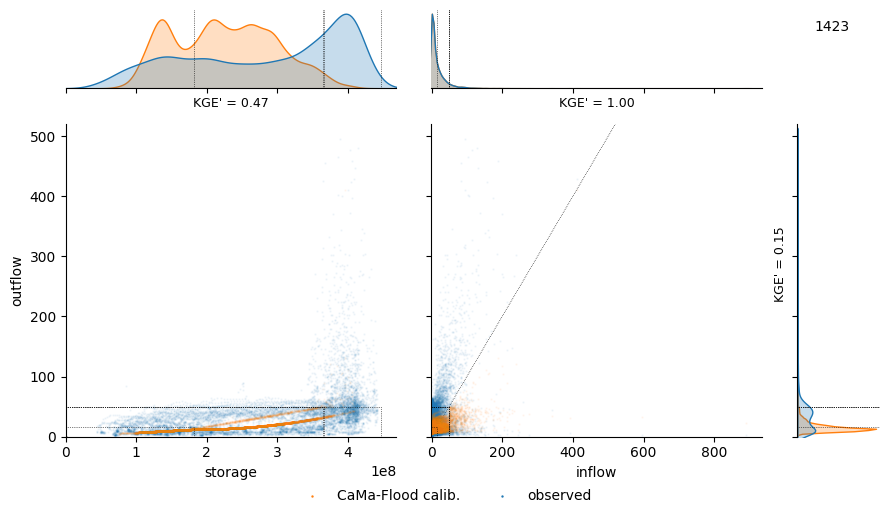

In [57]:
res.scatter(
    sim_cal.iloc[365:],
    cal_ts.iloc[365:],
    norm=False,
    title=gdw_id,
    Vlims=Vlims,
    Qlims=Qlims,
    labels=['CaMa-Flood calib.', 'observed'],
    # save=path_results / f'{gdw_id}_scatter_CaMa-Flood_vs_observed.jpg'
)

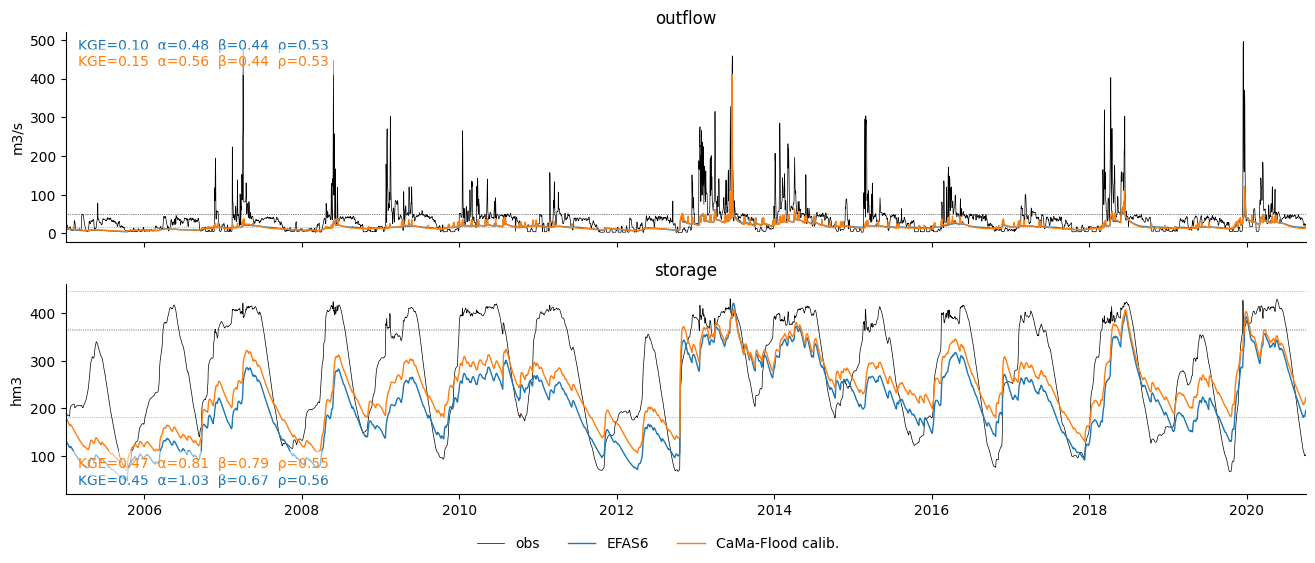

In [85]:
res.lineplot(
    sim={
        'EFAS6': efas6_d.iloc[365:],
        'CaMa-Flood calib.': sim_cal.iloc[365:],
    },
    obs=hydro.iloc[365:],
    Vlims=Vlims,
    Qlims=Qlims,
    # spinup=cfg.SPINUP,
    title=gdw_id,
    figsize=(16, 6),
    xlim=(datetime(2005, 1, 1), datetime(2020, 9, 30))
    # save=path_results / f'{gdw_id}_line_CaMa-Flood_vs_observed.jpg'
)

Calibrating the reservoir parameters given the inflow from EFAS6 can only improve the performance very slightly (0.02 in terms of both outflow and storage).

## Conclusion